# Simulation of performance of polarimeter

We define experimentally polarizers and waveplates (ideal and real) and determine the intensity.
This functions are for calibration.

For linear polarizer I have found a simple way to determine p0 and p1, but for retarder it is not so easy. 

With mathematica I have found several equations and I can check the performance.



## Init definitions

In [1]:
from __future__ import print_function, division

# configuration
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'

In [5]:
import polarimeter
from scipy import optimize

In [3]:
# import modules
from phyton_optics import sp, plt, mm, um, nm, degrees, np
import phyton_optics.polarization_stokes as polarization
from phyton_optics.polarization_stokes import (
    intensity, polarized_light, polarizer_linear, quarter_waveplate, rotate_mueller, retarder, vacuum)

from polarimeter.polarimeter import get_polarimeter_parameters, polarimeter_matrices, rotate_polarimeter, polarimeter_matrix
from scipy import sin, cos,pi

from pprint import  pprint
np.set_printoptions(precision=4)
sp.set_printoptions(precision=4)

In [4]:
def dibujar_resultado(angles_2, angles_4, Intensidad, title=''):
    
    plt.figure()
    extension=sp.array([angles_2[0], angles_2[-1], angles_4[0], angles_4[-1]])*180/pi
    IDimage = plt.imshow(
        Intensidad,
        interpolation='bilinear',
        aspect='auto',
        origin='lower',
        extent=extension)
    plt.xlabel("$\phi_2$")
    plt.ylabel("$\phi_4$")
    plt.suptitle(title)
    #plt.axis('scaled')
    plt.axis(extension)
    plt.axis('scaled')

    # plt.axis('off')
    plt.colorbar()
    IDimage.set_cmap("magma") # YlGnBu  RdBu

# Ajuste

Definimos una función que genera la distribución de intensidad, que es la que intentamos optimizar

In [9]:
angles_2=sp.linspace(0, pi/2,11)
angles_4=sp.linspace(0, pi,11)

## Definición de funcion de ajuste

In [10]:
def polarimeter_matrices_parameters(par):
    """Se introducen los parámetros que definen las matrices y devuelve las matrices"""
    p0,p1,a,b, delta, theta_2, theta_4=par
    pol1 = dict(theta_axis=0, p0=p0, p1=p1)
    pol2 = dict(theta_axis=theta_2, a=a, b=b, delta=delta)
    pol3 = dict(theta_axis=0, a=a, b=b, delta=delta)
    pol4 = dict(theta_axis=theta_4, p0=p0, p1=p1)
    
    pol_param=[pol1, pol2, pol3, pol4]
    P = polarimeter_matrices(pol_param, angles=None)
    # pprint(P)
    return P

In [11]:
def polarimeter_behaviour(par):
      
    u0=polarized_light(amplitude=1, angle=0 * degrees, phase=sp.pi/2, pol_degree=1)
    is_polarizer=[True, True, False, True]
    
    P=polarimeter_matrices_parameters(par)
    angles_2=sp.linspace(0, pi/2,11)
    angles_4=sp.linspace(0, pi,11)
    Angles_2, Angles_4 = sp.meshgrid(angles_2, angles_4)
    Intensities=sp.zeros_like(Angles_2, dtype=float)

    for i2, angle_2 in enumerate(angles_2):
        for i4, angle_4 in enumerate(angles_4):
            Intensities[i2,i4], _ = polarimeter_matrix(P, is_present=is_polarizer, 
                                                     angles=[0,angle_2,0,angle_4], u0=u0)
    return Intensities

### Simulation of experiment

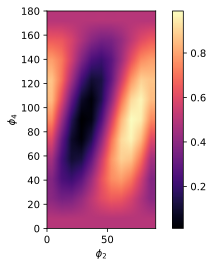

In [26]:
param_experimental=[0,1,1,1, pi/2, 45*degrees, 30*degrees]
I_experimental=polarimeter_behaviour(param_experimental)
dibujar_resultado(angles_2, angles_4, example    )

In [19]:
err_func = lambda p0,p1,a,b, delta, theta_2, theta_4: polarimeter_behaviour(p0,p1,a,b, delta, theta_2, theta_4) - I_experimental # Distance to the target function

In [21]:
def err_func(par):
    return abs(polarimeter_behaviour(par) - I_experimental ).flatten()

In [22]:
par=[0.128242248318,0.946436027636,1,1, pi/2, 134.39*degrees, 70.445*degrees]
error=err_func(par)
print(error.mean())


0.24893670626130565


In [23]:
#p0,p1,a,b, delta)
params_ini=[0,1, .9, .8, sp.pi/2, 0, 0]

params_ini=[0.128242248318,0.946436027636,1,1, pi/2, 0*degrees, 90.445*degrees]

params_optim, success = optimize.leastsq(err_func, params_ini)
print(params_optim)
print(params_optim*180/sp.pi)

[ 0.0001  1.      1.      1.      4.7124 -0.7854  0.5236]
[  0.0034  57.2958  57.2958  57.2958 270.     -45.      30.    ]


mean residual = 1.193e-09


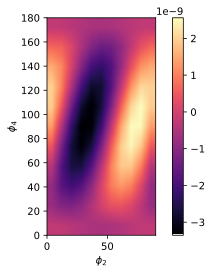

In [25]:
Intensities_fitting = polarimeter_behaviour(params_optim)
residuals= I_experimental - Intensities_fitting
dibujar_resultado(angles_2, angles_4, residuals)    
print("mean residual = {:2.4}".format(abs(residuals).mean()))

#### comparison between intial and final parameters

In [27]:
params_optim-param_experimental

array([ 0.0001, -0.    ,  0.    ,  0.    ,  3.1416, -1.5708,  0.    ])

p0,p1,a,b, delta, theta_2, theta_4

Estas diferencias son acetpables, por cuanto el desfase tiene una diferencia de $\pi$ y el ángulo de la lámina lambda cuartos tiene una diferencia de $\pi/2$